# import needed modules 

In [2]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import AUC

# classes Grouping

In [3]:
base_dir = "/kaggle/input/brain-tumor-mri-images-44c"

filepaths = []
labels = []

# Mapping 44 folders to 15 grouped classes
class_mapping = {
    "astrocitoma": "Astrocytoma",
    "carcinoma": "Carcinoma",
    "ependimoma": "Ependymoma",
    "ganglioglioma": "Ganglioglioma",
    "germinoma": "Germinoma",
    "glioblastoma": "Glioblastoma",
    "granuloma": "Granuloma",
    "meduloblastoma": "Medulloblastoma",
    "meningioma": "Meningioma",
    "neurocitoma": "Neurocytoma",
    "oligodendroglioma": "Oligodendroglioma",
    "papiloma": "Papilloma",
    "schwannoma": "Schwannoma",
    "tuberculoma": "Tuberculoma",
    "_normal": "Normal"
}

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)

    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        if file.lower().endswith((".jpg", ".jpeg", ".webp")):  
            file_path = os.path.join(folder_path, file)
            base_class = folder.split()[0].lower()
            label = class_mapping.get(base_class, "Unknown")
            filepaths.append(file_path)
            labels.append(label)

df = pd.DataFrame({
    "filepaths": filepaths,
    "labels": labels
})

print("Total images loaded:", len(df))
print("\nClass Distribution:")
print(df['labels'].value_counts())

df


Total images loaded: 4479

Class Distribution:
labels
Meningioma           874
Astrocytoma          580
Normal               522
Schwannoma           465
Neurocytoma          457
Carcinoma            251
Papilloma            237
Oligodendroglioma    224
Glioblastoma         204
Ependymoma           150
Tuberculoma          145
Medulloblastoma      131
Germinoma            100
Granuloma             78
Ganglioglioma         61
Name: count, dtype: int64


,filepaths,labels
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papilloma
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papilloma
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papilloma
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papilloma
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papilloma
...,...,...
4474,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma
4475,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma
4476,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma
4477,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma


In [4]:
class_counts = df['labels'].value_counts()
print(class_counts)

labels
Meningioma           874
Astrocytoma          580
Normal               522
Schwannoma           465
Neurocytoma          457
Carcinoma            251
Papilloma            237
Oligodendroglioma    224
Glioblastoma         204
Ependymoma           150
Tuberculoma          145
Medulloblastoma      131
Germinoma            100
Granuloma             78
Ganglioglioma         61
Name: count, dtype: int64


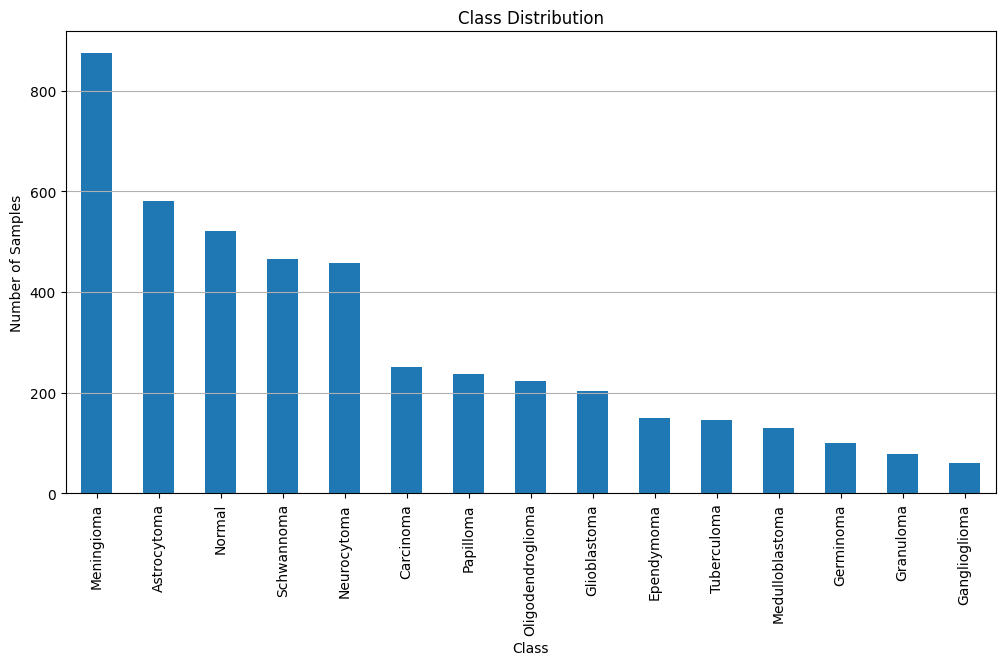

In [5]:
# Optional: visualize
class_counts.plot(kind='bar', figsize=(12, 6), title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.show()

# Class Balancing

In [6]:
max_count = df['labels'].value_counts().max()

upsampled_dfs = []
for label in df['labels'].unique():
    df_class = df[df['labels'] == label]
    if len(df_class) < max_count:
        df_upsampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
    else:
        df_upsampled = df_class
    upsampled_dfs.append(df_upsampled)

balanced_df = pd.concat(upsampled_dfs).sample(frac=1).reset_index(drop=True)

In [7]:
train_df, dummy_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, stratify=dummy_df['labels'], random_state=42)

#  Data Generators with Augmentation

data generators with augmentation for training and simple rescaling for validation/testing

In [8]:
def create_data_generators(train_df, valid_df, test_df, batch_size=32, img_size=(224, 224)):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.9, 1.1],
        fill_mode='nearest'
    )
    
    eval_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )
    
    valid_gen = eval_datagen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    
    test_gen = eval_datagen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_gen, valid_gen, test_gen



In [ ]:





# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# img_size = (224, 224)

# # Augmentation for training
# train_gen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Validation & test only rescale
# valid_test_gen = ImageDataGenerator(rescale=1./255)

# # Create generators
# train_generator = train_gen.flow_from_dataframe(
#     balanced_train_df,
#     x_col='filepaths',
#     y_col='labels',
#     target_size=img_size,
#     class_mode='categorical',
#     color_mode='rgb',
#     batch_size=32,
#     shuffle=True
# )

# valid_generator = valid_test_gen.flow_from_dataframe(
#     valid_df,
#     x_col='filepaths',
#     y_col='labels',
#     target_size=img_size,
#     class_mode='categorical',
#     color_mode='rgb',
#     batch_size=32,
#     shuffle=False
# )

# test_generator = valid_test_gen.flow_from_dataframe(
#     test_df,
#     x_col='filepaths',
#     y_col='labels',
#     target_size=img_size,
#     class_mode='categorical',
#     color_mode='rgb',
#     batch_size=32,
#     shuffle=False
# )




# img_size = (224, 224)
# train_gen = ImageDataGenerator(rescale=1./255)
# valid_test_gen = ImageDataGenerator(rescale=1./255)

# train_generator = train_gen.flow_from_dataframe(
#     train_df, x_col='filepaths', y_col='labels', target_size=img_size,
#     class_mode='categorical', color_mode='rgb', batch_size=32, shuffle=True)

# valid_generator = valid_test_gen.flow_from_dataframe(
#     valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
#     class_mode='categorical', color_mode='rgb', batch_size=32, shuffle=False)

# test_generator = valid_test_gen.flow_from_dataframe(
#     test_df, x_col='filepaths', y_col='labels', target_size=img_size,
#     class_mode='categorical', color_mode='rgb', batch_size=32, shuffle=False)

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(generator, max_images=25):
    """
    Display sample images from a data generator.

    Parameters:
        generator: Keras ImageDataGenerator flow (train/valid/test generator).
        max_images (int): Max number of images to display (default is 25).
    """
    class_indices = generator.class_indices
    classes = list(class_indices.keys())

    images, labels = next(generator)

    num_images = min(len(images), max_images)

    plt.figure(figsize=(15, 15))

    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])
        class_name = classes[label_index]
        plt.title(class_name, color='blue', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Found 3134 validated image filenames belonging to 15 classes.
Found 672 validated image filenames belonging to 15 classes.
Found 672 validated image filenames belonging to 15 classes.


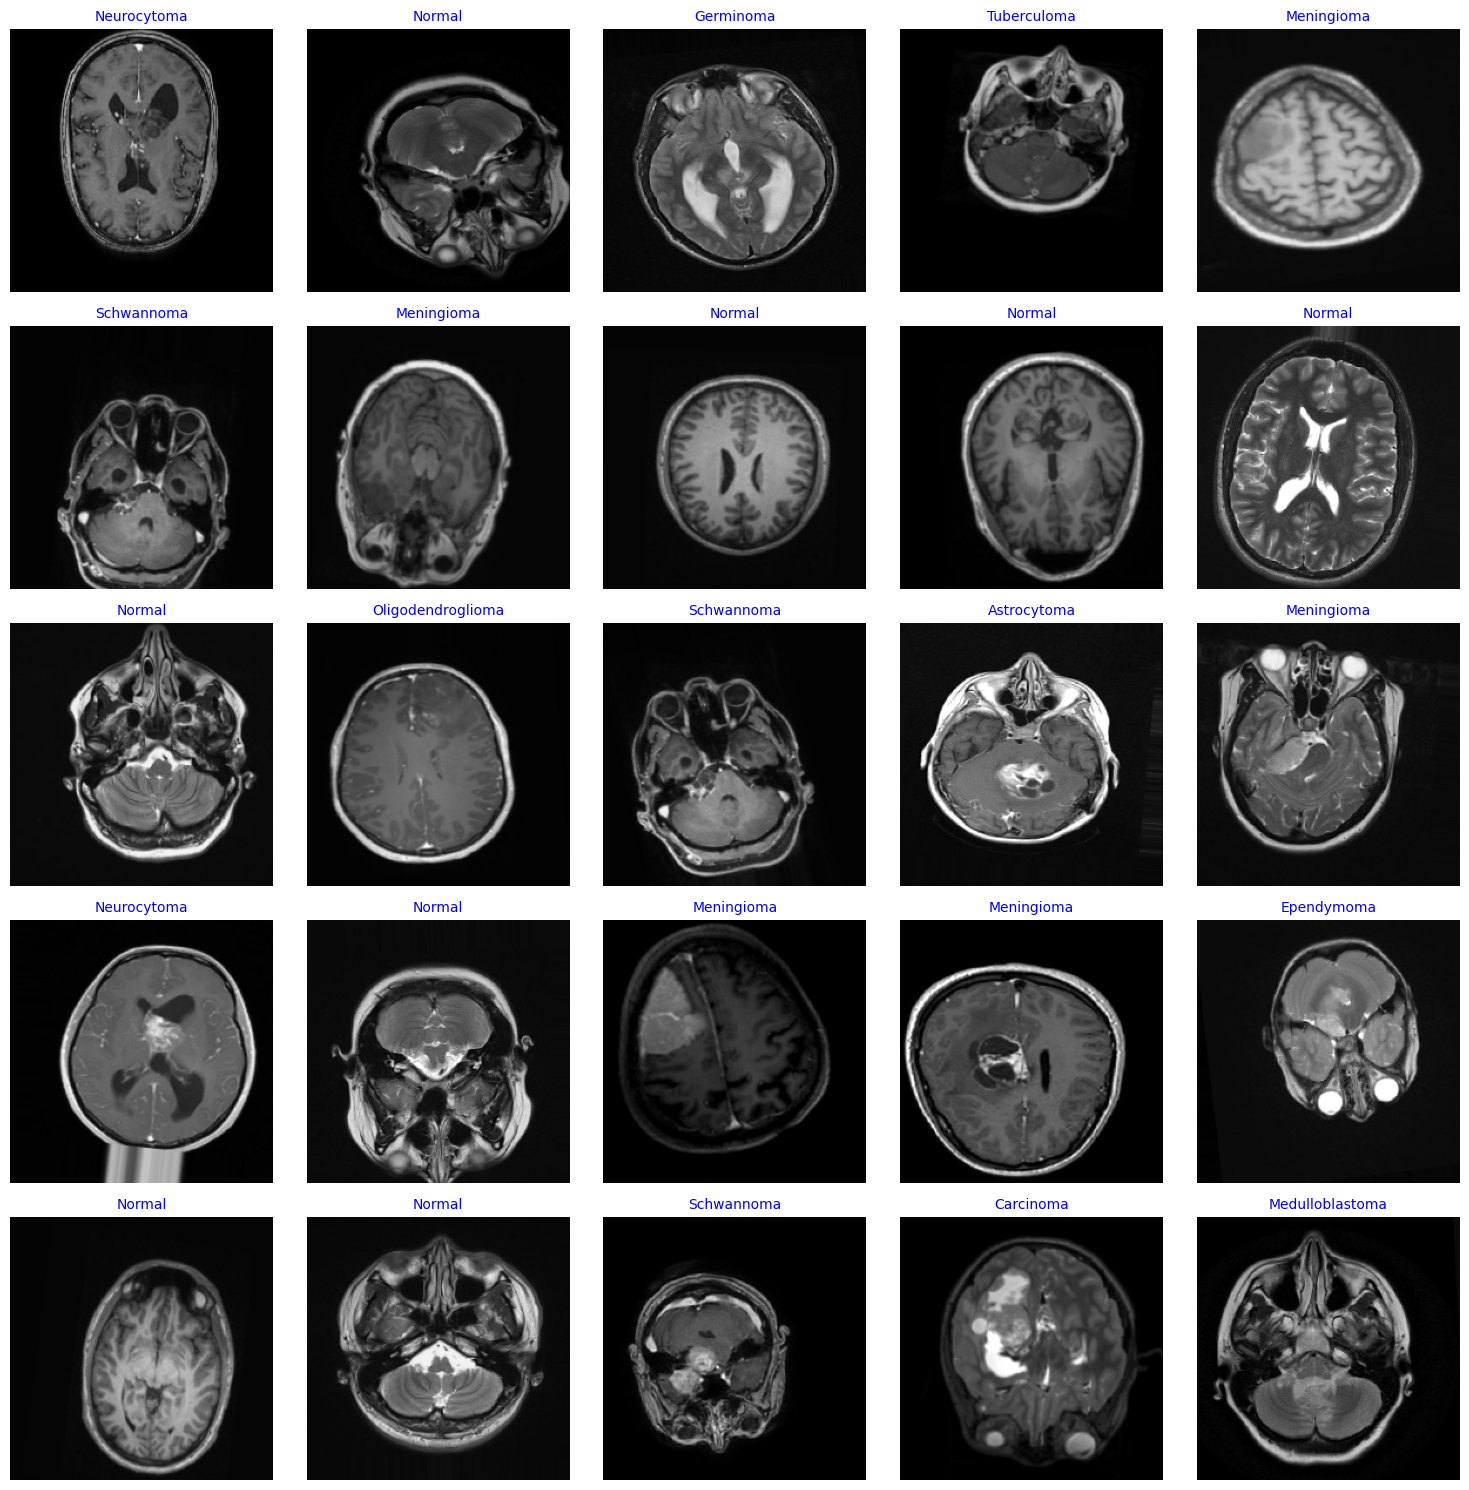

In [10]:
# Create the generators first
train_gen, valid_gen, test_gen = create_data_generators(train_df, valid_df, test_df)

# Show images from the training generator
show_images(train_gen)


### Class Weights to Address Imbalanced Classes

In [11]:
train_gen, valid_gen, test_gen = create_data_generators(train_df, valid_df, test_df)

class_indices = train_gen.class_indices
label_map = train_df['labels'].map(class_indices)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label_map),
    y=label_map
)

class_weights = dict(enumerate(class_weights))



Found 3134 validated image filenames belonging to 15 classes.
Found 672 validated image filenames belonging to 15 classes.
Found 672 validated image filenames belonging to 15 classes.


# Callback function

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def get_callbacks(weights_path='best_model_weights.h5', patience=5):
   
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=patience*2,
            verbose=1,
            restore_best_weights=True
        ),
        
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=patience,
            verbose=1
        ),
        
        ModelCheckpoint(
            filepath=weights_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),

        
        F1ScoreCallback(),
        
        TensorBoard(log_dir='./logs', histogram_freq=1),

    ]

class F1ScoreCallback(Callback):
    """Calculates macro F1 score after each epoch"""
    def __init__(self, validation_data=None):
        super().__init__()
        self.validation_data = validation_data
    
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data:
            val_pred = []
            val_true = []
            
            for x, y in self.validation_data:
                pred = self.model.predict(x, verbose=0)
                val_pred.extend(np.argmax(pred, axis=1))
                val_true.extend(np.argmax(y, axis=1))
            
            f1 = f1_score(val_true, val_pred, average='macro')
            logs['val_f1'] = f1  # Store in logs
            print(f" - val_f1: {f1:.4f}")  # Print

In [ ]:
# import time
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from sklearn.metrics import f1_score

# class MyCallback(keras.callbacks.Callback):
#     def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
#         super(MyCallback, self).__init__()
#         self.patience = patience
#         self.stop_patience = stop_patience
#         self.threshold = threshold
#         self.factor = factor
#         self.batches = batches
#         self.epochs = epochs
#         self.ask_epoch = ask_epoch
#         self.ask_epoch_initial = ask_epoch

#         self.count = 0
#         self.stop_count = 0
#         self.best_epoch = 1
#         self.highest_tracc = 0.0
#         self.lowest_vloss = np.inf
#         self.best_weights = None
#         self.initial_weights = None

#         self.val_data = val_data

#     def on_train_begin(self, logs=None):
#         msg = 'Do you want model to ask you before halting training? [y/n]'
#         print(msg)
#         ans = input('').strip().lower()
#         self.ask_permission = 1 if ans == 'y' else 0

#         self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
#         self.best_weights = self.model.get_weights()
#         self.initial_weights = self.model.get_weights()

#         header = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^10s}{9:^8s}'.format(
#             'Epoch', 'Loss', 'Accuracy', 'V_Loss', 'V_Acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
#         )
#         print(header)
#         self.start_time = time.time()

#     def on_train_end(self, logs=None):
#         stop_time = time.time()
#         duration = stop_time - self.start_time
#         hours = int(duration // 3600)
#         minutes = int((duration % 3600) // 60)
#         seconds = duration % 60
#         print(f"Training duration: {hours}h {minutes}m {seconds:.2f}s")

#         self.model.set_weights(self.best_weights)

#     def on_train_batch_end(self, batch, logs=None):
#         acc = logs.get('accuracy', 0) * 100
#         loss = logs.get('loss', 0)
#         msg = f'Processing batch {batch + 1}/{self.batches} - Accuracy: {acc:.3f}% - Loss: {loss:.5f}'
#         print(msg, end='\r')

#     def on_epoch_begin(self, epoch, logs=None):
#         self.ep_start = time.time()

#     def on_epoch_end(self, epoch, logs=None):
#         ep_end = time.time()
#         duration = ep_end - self.ep_start

#         # Get the current learning rate and logs
#         lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))  # Ensure correct lr assignment
#         current_lr = lr
#         acc = logs.get('accuracy', 0)
#         v_acc = logs.get('val_accuracy', 0)
#         loss = logs.get('loss', 0)
#         v_loss = logs.get('val_loss', 0)

#         if acc < self.threshold:
#             monitor = 'accuracy'
#             pimprov = 0.0 if epoch == 0 else (acc - self.highest_tracc) * 100 / self.highest_tracc

#             if acc > self.highest_tracc:
#                 self.highest_tracc = acc
#                 self.best_weights = self.model.get_weights()
#                 self.count = 0
#                 self.stop_count = 0

#                 if v_loss < self.lowest_vloss:
#                     self.lowest_vloss = v_loss
#                 self.best_epoch = epoch + 1
#             else:
#                 if self.count >= self.patience - 1:
#                     lr *= self.factor
#                     self.model.optimizer.learning_rate.assign(lr)  # Correct method to update lr
#                     self.count = 0
#                     self.stop_count += 1
#                     if v_loss < self.lowest_vloss:
#                         self.lowest_vloss = v_loss
#                 else:
#                     self.count += 1
#         else:
#             monitor = 'val_loss'
#             pimprov = 0.0 if epoch == 0 else (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

#             if v_loss < self.lowest_vloss:
#                 self.lowest_vloss = v_loss
#                 self.best_weights = self.model.get_weights()
#                 self.count = 0
#                 self.stop_count = 0
#                 self.best_epoch = epoch + 1
#             else:
#                 if self.count >= self.patience - 1:
#                     lr *= self.factor
#                     self.model.optimizer.learning_rate.assign(lr)  # Correct method to update lr
#                     self.count = 0
#                     self.stop_count += 1
#                 else:
#                     self.count += 1

#             if acc > self.highest_tracc:
#                 self.highest_tracc = acc

#         # Logging
#         msg = f'{epoch + 1:^3d}/{self.epochs:<3d} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
#         print(msg)

#         # Check for stopping conditions
#         if self.stop_count > self.stop_patience - 1:
#             print(f'\nTraining halted at epoch {epoch + 1} after {self.stop_patience} learning rate adjustments with no improvement.')
#             self.model.stop_training = True
#         elif self.ask_epoch is not None and self.ask_permission != 0:
#             if epoch + 1 >= self.ask_epoch:
#                 print('Enter H to halt training or a number of additional epochs before next prompt:')
#                 ans = input('').strip()
#                 if ans.lower() == 'h':
#                     print(f'Training halted at epoch {epoch + 1} due to user request.')
#                     self.model.stop_training = True
#                 else:
#                     try:
#                         self.ask_epoch += int(ans)
#                         print(f'Training will continue to epoch {self.ask_epoch}.')
#                         print('{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^10s}{9:^8s}'.format(
#                             'Epoch', 'Loss', 'Accuracy', 'V_Loss', 'V_Acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'
#                         ))
#                     except:
#                         print('Invalid input, ignoring.')
#                 # F1 Score evaluation (optional)
#         if self.val_data is not None:
#             val_preds = []
#             val_labels = []

#             for x, y in self.val_data:
#                 preds = self.model.predict(x, verbose=0)
#                 val_preds.extend(np.argmax(preds, axis=1))
#                 val_labels.extend(np.argmax(y, axis=1))

#             f1 = f1_score(val_labels, val_preds, average='macro')
#             print(f"Epoch {epoch+1} - F1 Score (macro): {f1:.4f}")



# Functions for Model Results

In [14]:
def plot_training(hist):

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    loss_label = f'Best epoch = {str(index_loss + 1)}'
    acc_label = f'Best epoch = {str(index_acc + 1)}'
    
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  

    plt.tight_layout()

    plt.show()

In [15]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [17]:
!pip install tensorflow-addons

# Model Structure

In [32]:
from tensorflow.keras import regularizers

def build_model(input_shape=(224, 224, 3), num_classes=15):

    base_model = ResNet50V2(
        weights='imagenet', 
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False
    
    for layer in base_model.layers[-10:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            if hasattr(layer, 'kernel_regularizer'):
                layer.kernel_regularizer = regularizers.l2(1e-4)

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)  
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(
        96, 
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-3)  
    )(x)
    x = layers.Dropout(0.7)(x)  
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-3)
    )(x)
    x = layers.Dropout(0.6)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    optimizer = Adam(
        learning_rate=3e-5,  
        beta_1=0.9,
        beta_2=0.999,
        clipnorm=1.0 
    )
    
    loss = CategoricalCrossentropy(
        label_smoothing=0.15  
    )
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', AUC(name='auc')]
    )
    
    return model

In [33]:
model = build_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,844,495 (90.96 MB)

 Trainable params: 8,144,015 (31.07 MB)

 Non-trainable params: 15,700,480 (59.89 MB)

In [34]:
train_gen, val_gen, test_gen = create_data_generators(train_df, valid_df, test_df)
history = model.fit(
    train_gen,
    callbacks=get_callbacks(weights_path='brain_tumor_best_weights.keras'),
    validation_data=valid_gen,
    epochs=40,
    verbose=1
)

Found 3134 validated image filenames belonging to 15 classes.
Found 672 validated image filenames belonging to 15 classes.
Found 672 validated image filenames belonging to 15 classes.
Epoch 1/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1318 - auc: 0.5952 - loss: 2.9660
Epoch 1: val_loss improved from inf to 2.46019, saving model to brain_tumor_best_weights.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - accuracy: 0.1322 - auc: 0.5956 - loss: 2.9642 - val_accuracy: 0.3199 - val_auc: 0.7511 - val_loss: 2.4602 - learning_rate: 1.0000e-04
Epoch 2/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2963 - auc: 0.7539 - loss: 2.4081
Epoch 2: val_loss improved from 2.46019 to 2.26496, saving model to brain_tumor_best_weights.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 404s 4s/step - accuracy: 0.2966 - auc: 0.7541 - loss: 2.4074 - val_accuracy: 0.3899 - val_auc: 0.8291 - val_loss: 2.2650 - learning_rate: 1.0000e-04
Epoch 3/40
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3767 - auc: 0

# Model Results

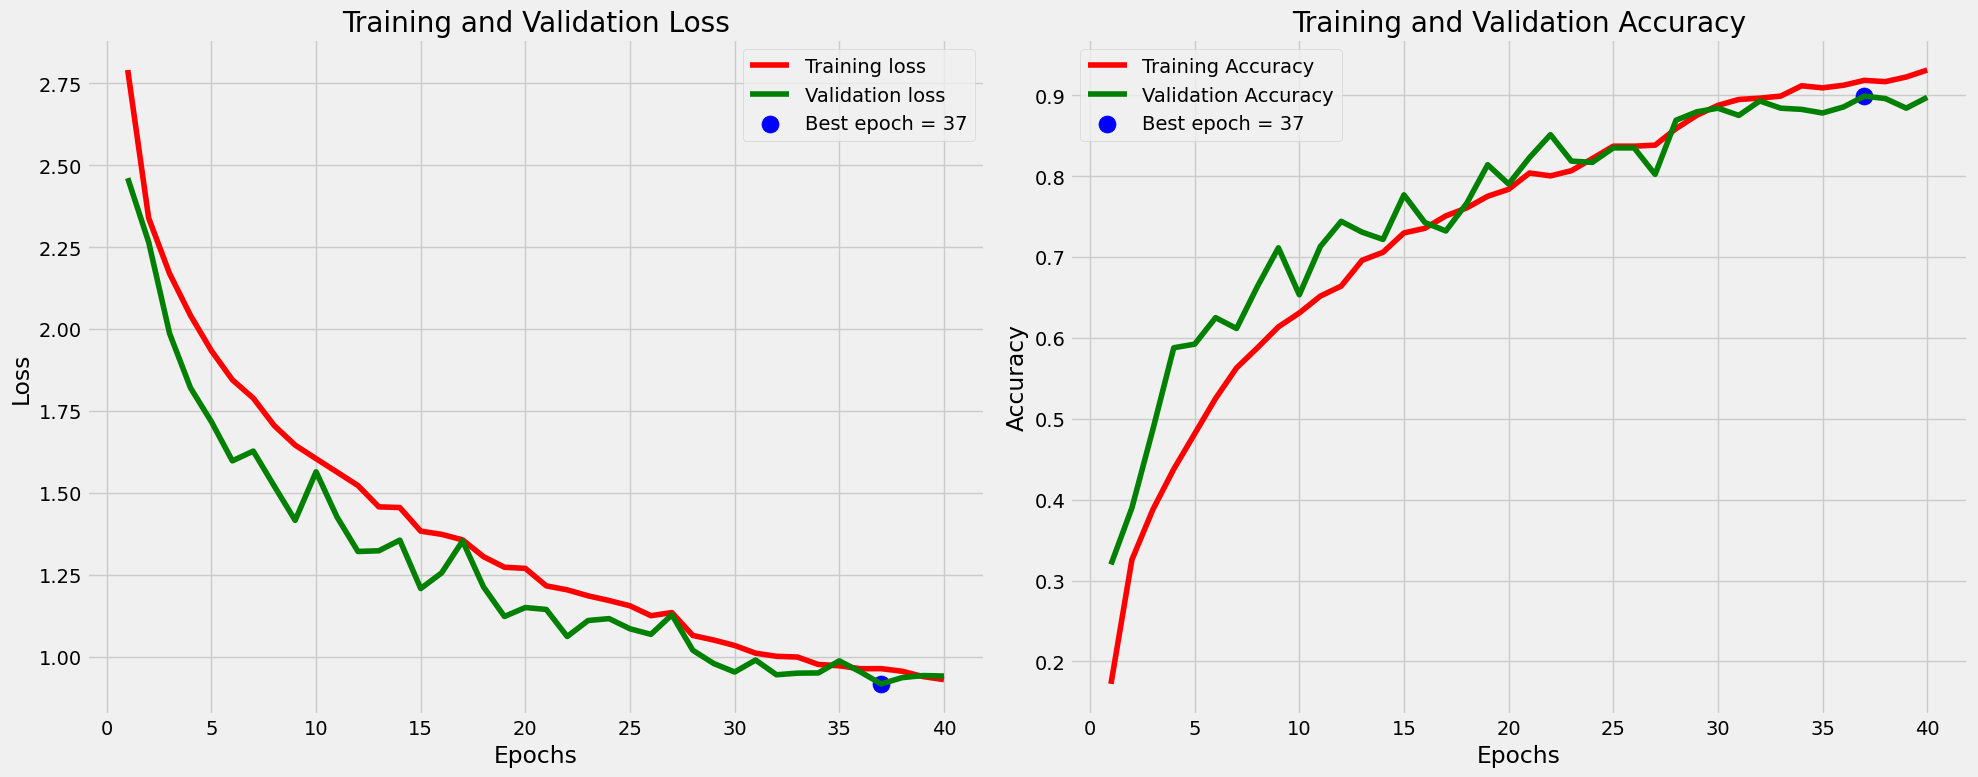

In [35]:
plot_training(history)

In [36]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9621 - auc: 0.9997 - loss: 0.7552
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8873 - auc: 0.9950 - loss: 0.9348
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8647 - auc: 0.9941 - loss: 0.9703
Train Loss:  0.7614244818687439
Train Accuracy:  0.9635416865348816
--------------------
Validation Loss:  0.9233181476593018
Validation Accuracy:  0.8932291865348816
--------------------
Test Loss:  0.9401625990867615
Test Accuracy:  0.8854166865348816


21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step
Confusion Matrix, Without Normalization
[[ 75   0   1   0   0   1   0   2   4   0   3   1   0   0   0]
 [  0  35   0   0   0   1   0   0   1   0   0   0   0   0   0]
 [  1   0  18   0   0   0   0   1   1   0   1   0   0   0   0]
 [  1   0   0   5   1   0   0   0   0   0   2   0   0   0   0]
 [  1   0   0   0  12   1   0   0   0   0   0   1   0   0   0]
 [  1   0   0   0   0  30   0   0   0   0   0   0   0   0   0]
 [  0   0   2   0   0   0   7   1   0   0   0   0   0   2   0]
 [  0   0   1   0   1   0   0  17   0   0   0   0   0   1   0]
 [  2   1   0   1   0   2   0   1 116   2   2   0   0   4   0]
 [  0   1   2   1   2   1   0   0   1  60   0   0   0   1   0]
 [  0   0   2   1   0   0   0   0   0   0  74   0   0   1   0]
 [  0   0   0   0   0   0   0   0   3   0   1  30   0   0   0]
 [  1   0   1   0   0   0   0   0   0   0   0   0  30   3   0]
 [  1   0   2   0   0   1   0   1   0   0   0   0   0  65   0]
 [  3   0   0   0   0   1   1   0   0  

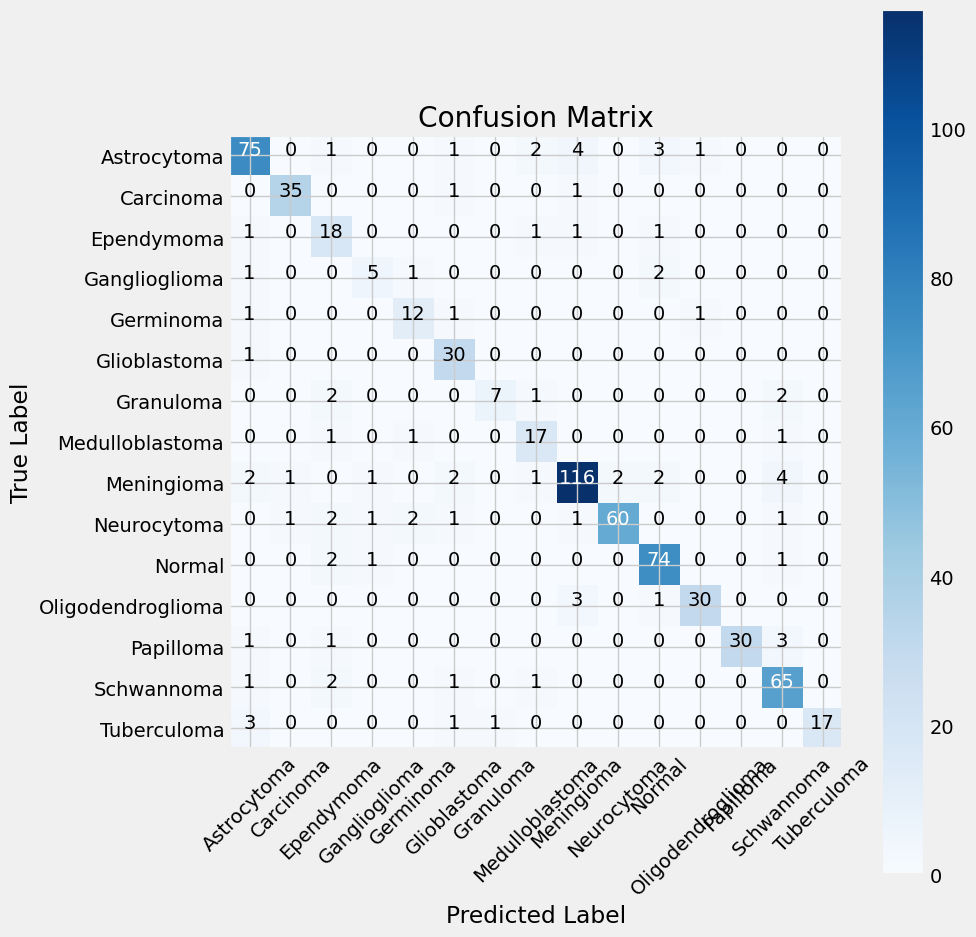

In [37]:

import itertools
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_gen, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)  

true_classes = test_gen.classes
class_names = test_gen.class_indices.keys()

cm = confusion_matrix(true_classes, predicted_classes)

plot_confusion_matrix(cm, classes=class_names, normalize=False, title='Confusion Matrix')
